In [1]:
import sys

sys.path.append("..")

In [2]:
import os
from dataclasses import dataclass
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from torch import optim
from torch.optim import lr_scheduler
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision import transforms as T
from tqdm import tqdm

%matplotlib inline

In [3]:
run_name = "exp015"

@dataclass
class InputPath:
    _prefix: str = "../input"
    train_images: str = f"{_prefix}/christ-train-imgs.npz"
    train_labels: str = f"{_prefix}/christ-train-labels.npz"
    test_images: str = f"{_prefix}/christ-test-imgs.npz"
        
        
@dataclass
class OutputPath:
    _prefix: str = "../output"
    logs: str = f"{_prefix}/logs"
    model: str = f"{_prefix}/model"
    submission: str = f"{_prefix}/submission"
     
        
def load_npz(path: str) -> np.array:
    return np.load(path)["arr_0"]


def generate_kf() -> Generator:
    kf = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42,
    )
    return kf

In [4]:
class ProbSpaceDataset(data.Dataset):
    IMG_MEAN = [0.485, 0.456, 0.406]
    IMG_STD = [0.229, 0.224, 0.225]

    def __init__(
        self, images: np.array, labels: Optional[np.array] = None, is_train: bool = True
    ) -> None:
        """images.shape: (b, h, w, c), labels: (b,)"""
        assert (is_train and labels is not None) or (not is_train and labels is None)
        self.is_train = is_train
        self.images = images
        self.labels = labels

        size = (224, 224)
        additional_items = (
            [
                T.ToPILImage(),
                T.Resize(size),
            ]
            if not is_train
            else [
                T.ToPILImage(),
                T.RandomGrayscale(p=0.2),
                T.RandomHorizontalFlip(),
                T.ColorJitter(
                    brightness=0.3,
                    contrast=0.5,
                    saturation=[0.8, 1.3],
                    hue=[-0.05, 0.05],
                ),
                T.RandomResizedCrop(size),
            ]
        )
        self.transformer = T.Compose(
            [
                *additional_items,
                T.ToTensor(),
#                 T.Normalize(mean=self.IMG_MEAN, std=self.IMG_STD),
            ]
        )

    def __getitem__(self, index) -> Dict[str, Any]:
        image = self.images[index]
        image = self.transformer(image)
        if self.is_train:
            label = self.labels[index]
        else:
            label = -1
        return {"image": image, "label": label}

    def __len__(self) -> int:
        return len(self.images)

    
    
class ProbSpaceModel(nn.Module):
    def __init__(self, model_name: str):
        super().__init__()
        self.backbone = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=13,
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.softmax(x)
        return x

    
def build_model():
    model = ProbSpaceModel(model_name="resnext50_32x4d")
    model.to("cuda")
    return model

In [5]:
train_images = load_npz(InputPath.train_images)
train_labels = load_npz(InputPath.train_labels)

train = pd.DataFrame({"target": train_labels})
kf = generate_kf()
kf_generator = kf.split(train, train["target"])
for fold_i, (tr_idx, val_idx) in enumerate(kf_generator):
    train.loc[val_idx, "fold"] = fold_i
train = train.assign(fold=train["fold"].astype(int))

In [6]:
n_fold = 0
trn_idx = train[train["fold"] != n_fold].index.tolist()
val_idx = train[train["fold"] == n_fold].index.tolist()
train_images_folds = train_images[trn_idx]
valid_images_folds = train_images[val_idx]
train_labels_folds = train_labels[trn_idx]
valid_labels_folds = train_labels[val_idx]
# train_folds = train.loc[trn_idx].reset_index(drop=True)
valid_folds = train.loc[val_idx].reset_index(drop=True)
train_dataset = ProbSpaceDataset(
    train_images_folds,
    train_labels_folds,
    is_train=True,
    #             transform=get_transforms(self.params, data="train"),
)
valid_dataset = ProbSpaceDataset(
    valid_images_folds,
    valid_labels_folds,
    is_train=True,
    #             transform=get_transforms(self.params, data="valid"),
)
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
)

model = build_model()
model.to("cuda")
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-5,
    weight_decay=0,
    amsgrad=False,
)
scheduler = scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.1,
    patience=5,
    verbose=True,
    eps=1e-8,
)
criterion = nn.CrossEntropyLoss()

## Mixup

In [7]:
@dataclass
class MixUpLabelData:
    labels_a: torch.tensor
    labels_b: torch.tensor
    lam: np.array


def mixup(batch: Dict[str, np.array], alpha: float = 1.0, seed: float = 42, imshow: bool = False) -> Tuple[np.array, MixUpLabelData]:
    images, labels = batch["image"], batch["label"]

    ### Shuffle Minibatch ###
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    indices = torch.randperm(images.size(0))
    images_s, labels_s = images[indices], labels[indices]
    
    lam = np.random.beta(alpha, alpha)
    images_mixup = lam * images + (1-lam) * images_s
    labels_mixup = MixUpLabelData(labels_a=labels, labels_b=labels_s, lam=lam)
    
    if imshow:
        plt.imshow(images[0].numpy().transpose(1,2,0))
        plt.title(f"pred_label={labels[0]}")
        plt.show()
        
        plt.imshow(images_s[0].numpy().transpose(1,2,0))
        plt.title(f"pred_label={labels_s[0]}")
        plt.show()
        
        plt.imshow(images_mixup[0].numpy().transpose(1,2,0))
        plt.title(f"pred_label={labels_mixup.labels_a[0]} {labels_mixup.labels_b[0]} {lam:.2f}")
        plt.show()
    
    return images_mixup, labels_mixup


def calc_loss_mixup(criterion, preds: torch.Tensor, labels: MixUpLabelData) -> float:
    labels_a, labels_b, lam = labels.labels_a.cuda(), labels.labels_b.cuda(), labels.lam
    loss = lam * criterion(preds, labels_a) + (1 - lam) * criterion(preds, labels_b)
    return loss

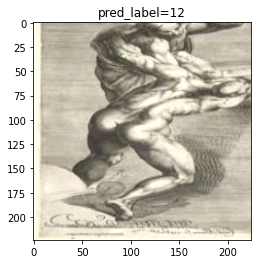

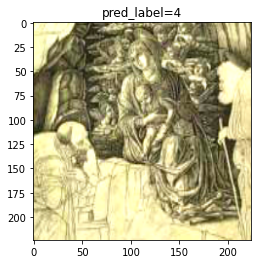

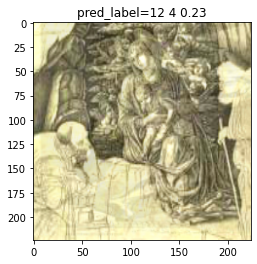

[1] loss: 4.866
Accuracy of the network on the 131 test images: 19 %


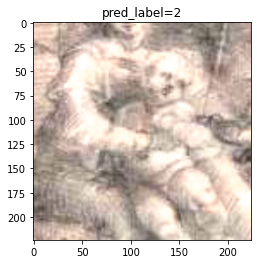

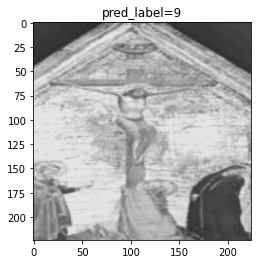

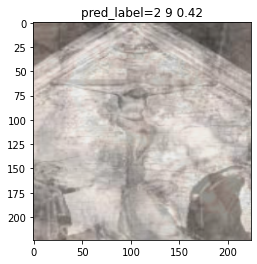

[2] loss: 4.857
Accuracy of the network on the 131 test images: 19 %


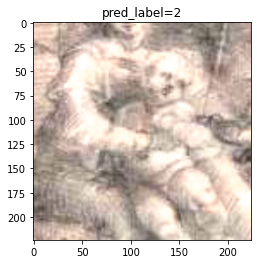

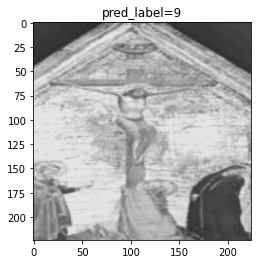

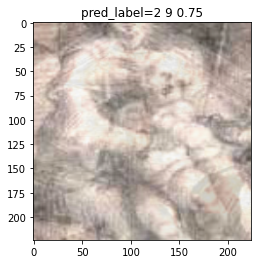

[3] loss: 4.829
Accuracy of the network on the 131 test images: 23 %


In [8]:
EPOCH = 3
for epoch in range(EPOCH):
    
    ################
    ### Training ###
    ################
    running_loss = 0.0
    for i, image_label_dict in enumerate(train_loader):
        data = mixup(image_label_dict, imshow=True if i ==0 else False)
        images, labels = data[0].cuda(), data[1]
        optimizer.zero_grad()
        y_preds = model(images)
        loss = calc_loss_mixup(criterion, y_preds, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('[%d] loss: %.3f' % (epoch + 1, running_loss / len(train_dataset) * i))


    ################
    ### Testing  ###
    ################
    correct = 0
    total = 0
    with torch.no_grad():
        for image_label_dict in valid_loader:
            images = image_label_dict.get("image").to("cuda")
            labels = image_label_dict.get("label").to("cuda")
            y_preds = model(images)
            _, predicted = torch.max(y_preds, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d test images: %d %%' % (len(valid_dataset), 100 * correct / total))

    scheduler.step(running_loss)

## Cutout

In [9]:
def cutout(batch: Dict[str, np.array], seed: float = 42, imshow: bool = False):
    import copy
    images, labels = batch["image"], batch["label"]

    images_s = torch.zeros_like(images)
    np.random.seed(seed)
    lam = np.random.uniform(0.0, 1.0)

    H, W = images.shape[2:]
    r_x = np.random.uniform(0, W)
    r_y = np.random.uniform(0, H)
    r_w = W * np.sqrt(1 - lam)
    r_h = H * np.sqrt(1 - lam)
    x1 = int(np.round(max(r_x - r_w / 2, 0)))
    x2 = int(np.round(min(r_x + r_w / 2, W)))
    y1 = int(np.round(max(r_y - r_h / 2, 0)))
    y2 = int(np.round(min(r_y + r_h / 2, H)))

    images_cutout = copy.deepcopy(images)
    images_cutout[:, :, x1:x2, y1:y2] = images_s[:, :, x1:x2, y1:y2]
    
    if imshow:
        plt.imshow(images_cutout[0].numpy().transpose(1,2,0))
        plt.title(f"pred_label={labels[0]} {lam:.2f}")
        plt.show()

    return images_cutout, labels

# lossは通常のロス
# loss = criterion(outputs, target)

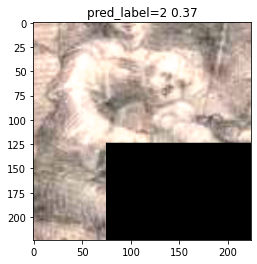

[1] loss: 4.822
Accuracy of the network on the 131 test images: 18 %


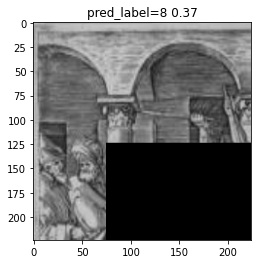

[2] loss: 4.782
Accuracy of the network on the 131 test images: 19 %


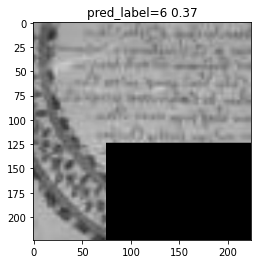

[3] loss: 4.715
Accuracy of the network on the 131 test images: 18 %


In [10]:
EPOCH = 3
for epoch in range(EPOCH):
    
    ################
    ### Training ###
    ################
    running_loss = 0.0
    for i, image_label_dict in enumerate(train_loader):
        data = cutout(image_label_dict, imshow=True if i ==0 else False)
        images, label = data[0].cuda(), data[1].cuda()
        optimizer.zero_grad()
        y_preds = model(images)
        loss = criterion(y_preds, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('[%d] loss: %.3f' % (epoch + 1, running_loss / len(train_dataset) * i))


    ################
    ### Testing  ###
    ################
    correct = 0
    total = 0
    with torch.no_grad():
        for image_label_dict in valid_loader:
            images = image_label_dict.get("image").to("cuda")
            labels = image_label_dict.get("label").to("cuda")
            y_preds = model(images)
            _, predicted = torch.max(y_preds, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d test images: %d %%' % (len(valid_dataset), 100 * correct / total))

    scheduler.step(running_loss)

## Cutmix

In [11]:
@dataclass
class CutMixLabelData:
    labels_a: torch.tensor
    labels_b: torch.tensor
    lam: np.array


def cutmix(batch: Dict[str, np.array], seed: float = 42, imshow: bool = True) -> Tuple[np.array, CutMixLabelData]:
    import copy
    

    images, labels = batch["image"], batch["label"]

    ### Shuffle Minibatch ###
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    indices = torch.randperm(images.size(0))
    images_s, labels_s = images[indices], labels[indices]

    lam = np.random.uniform(0.0, 1.0)

    H, W = images.shape[2:]
    r_x = np.random.uniform(0, W)
    r_y = np.random.uniform(0, H)
    r_w = W * np.sqrt(1 - lam)
    r_h = H * np.sqrt(1 - lam)
    x1 = int(np.round(max(r_x - r_w / 2, 0)))
    x2 = int(np.round(min(r_x + r_w / 2, W)))
    y1 = int(np.round(max(r_y - r_h / 2, 0)))
    y2 = int(np.round(min(r_y + r_h / 2, H)))

    images_cutmix = copy.deepcopy(images)
    images_cutmix[:, :, x1:x2, y1:y2] = images_s[:, :, x1:x2, y1:y2]
    labels_cutmix = CutMixLabelData(labels_a=labels, labels_b=labels_s, lam=lam)
    
    if imshow:
        plt.imshow(images[0].numpy().transpose(1,2,0))
        plt.title(f"pred_label={labels[0]}")
        plt.show()
        
        plt.imshow(images_s[0].numpy().transpose(1,2,0))
        plt.title(f"pred_label={labels_s[0]}")
        plt.show()
        
        plt.imshow(images_cutmix[0].numpy().transpose(1,2,0))
        plt.title(f"pred_label={labels_cutmix.labels_a[0]} {labels_cutmix.labels_b[0]} {lam:.2f}")
        plt.show()

    return images_cutmix, labels_cutmix


def calc_loss_cutmix(criterion, preds: torch.Tensor, labels: CutMixLabelData) -> float:
    labels_a, labels_b, lam = labels.labels_a.cuda(), labels.labels_b.cuda(), labels.lam
    loss = lam * criterion(preds, labels_a) + (1 - lam) * criterion(preds, labels_b)
    return loss

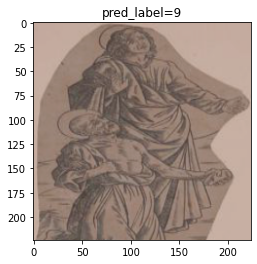

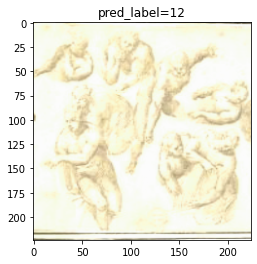

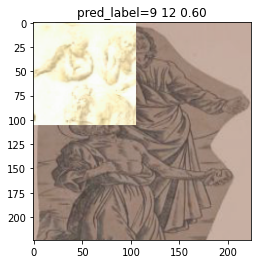

[1] loss: 4.747
Accuracy of the network on the 131 test images: 21 %


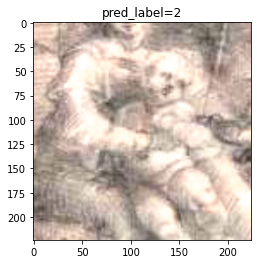

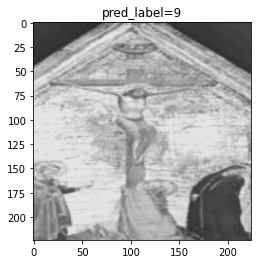

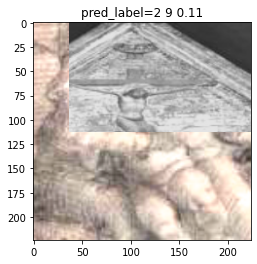

[2] loss: 4.708
Accuracy of the network on the 131 test images: 19 %


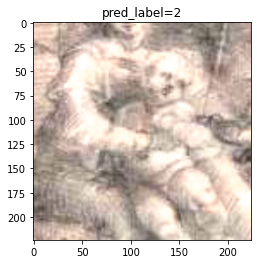

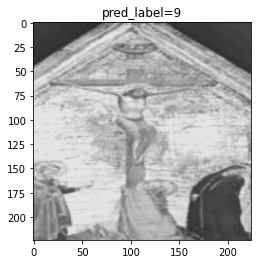

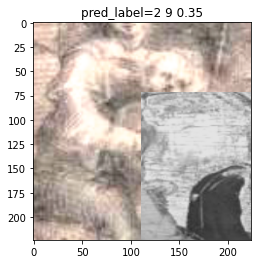

[3] loss: 4.667
Accuracy of the network on the 131 test images: 18 %


In [12]:
EPOCH = 3
for epoch in range(EPOCH):
    
    ################
    ### Training ###
    ################
    running_loss = 0.0
    for i, image_label_dict in enumerate(train_loader):
        data = cutmix(image_label_dict, imshow=True if i ==0 else False)
        images, labels = data[0].cuda(), data[1]
        optimizer.zero_grad()
        y_preds = model(images)
        loss = calc_loss_cutmix(criterion, y_preds, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('[%d] loss: %.3f' % (epoch + 1, running_loss / len(train_dataset) * i))


    ################
    ### Testing  ###
    ################
    correct = 0
    total = 0
    with torch.no_grad():
        for image_label_dict in valid_loader:
            images = image_label_dict.get("image").to("cuda")
            labels = image_label_dict.get("label").to("cuda")
            y_preds = model(images)
            _, predicted = torch.max(y_preds, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d test images: %d %%' % (len(valid_dataset), 100 * correct / total))

    scheduler.step(running_loss)